In [49]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import numpy as np
from sdeint import itoint
import jax.numpy as jnp

from utils import manifold, metrics
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

from joblib import Parallel, delayed
from functools import partial

# Default settings

In [97]:
rng = np.random.default_rng(0)
theta = 2 * np.pi * rng.uniform(size=200)
E = rng.uniform(size=(200))
init_x = np.sqrt(2*E[:, None]) * np.stack([np.cos(theta), np.sin(theta)], axis=-1)

gamma = 1e-2
tau = 2e-2
A = np.array([[0, 1], [-1, -gamma]])
G = np.diag(np.sqrt(2*gamma*tau)*np.ones(2))
tspan = np.linspace(0.0, 20000., 200001)

seeds = (1e10 * rng.uniform(size=200)).astype(int)

def itoint_(x, seed):
    return itoint(lambda x, t: A @ x, lambda x, t: G, x, tspan, generator=np.random.default_rng(seed))

data = np.stack(Parallel(n_jobs=200)(delayed(itoint_)(x, seed) for x, seed in zip(init_x, seeds)))
datasets = [data[:,:200:1], data[:,:2000:10], data[:,:20000:100], data[:,:200000:1000]]

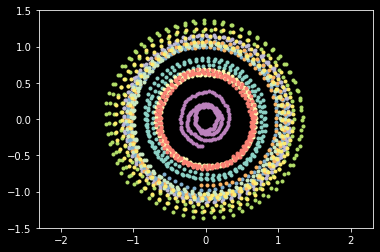

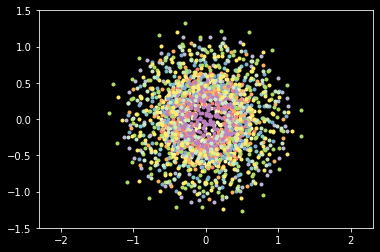

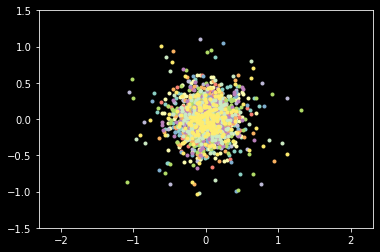

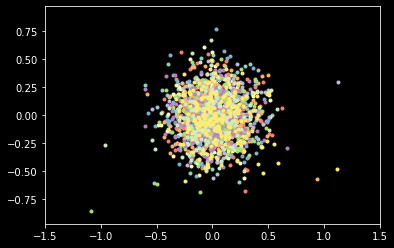

In [98]:
out_name = "langevin_sho"

for i in range(len(datasets)):
    plt.figure()
    plt.plot(datasets[i][:10, :, 0].T, datasets[i][:10, :, 1].T, '.')
    plt.axis('equal')
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)

In [33]:
dist_mats = []
for data in datasets:
    dist_mat, converged, _ = metrics.distance_matrix(data, mesh_shape=(4,2))
    assert converged.all()
    dist_mats.append(dist_mat)

In [36]:
# np.savez(out_name + "_dist_mats.npz", dist_mats=np.stack(dist_mats))
dist_mats = np.load(out_name + "_dist_mats.npz")['dist_mats']

nn_max = 0.35484644770622253
epsilon = 0.25183200289944985
mean_shift = 0.010150021
R^2 = 0.9761335371240507
Coefficent(s): [-0.56894547]
SpearmanrResult(correlation=0.9804620115502888, pvalue=8.680227473580427e-142)
nn_max = 0.26242315769195557
epsilon = 0.13773182738603396
mean_shift = 0.010089015
R^2 = 0.7695598097381963
Coefficent(s): [0.5018945]
SpearmanrResult(correlation=0.8699122478061952, pvalue=1.0779394103106042e-62)
nn_max = 0.1467771828174591
epsilon = 0.043087082791659626
mean_shift = 0.007703694
R^2 = 0.5205671486083586
Coefficent(s): [0.4127113]
SpearmanrResult(correlation=0.7579599489987252, pvalue=1.3568881832370587e-38)
nn_max = 0.10403454303741455
epsilon = 0.02164637229000732
mean_shift = 0.00780486
R^2 = 8.350850608795923e-07
Coefficent(s): [0.00052308]
SpearmanrResult(correlation=-0.030916534507065295, pvalue=0.6638606452421626)


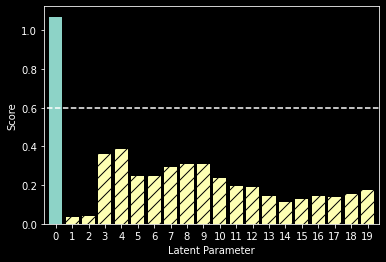

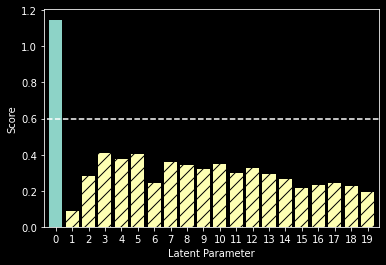

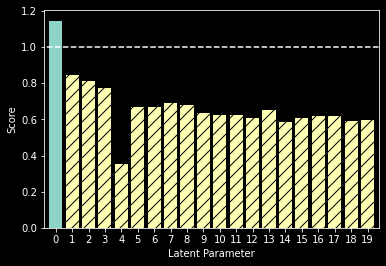

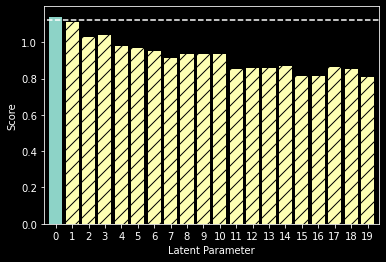

In [89]:
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

scores_pass_list = []
scores_fail_list = []
embedding_list = []
for i, dist_mat in enumerate(dist_mats):
    evals, embedding, epsilon = manifold.diffusion_map(dist_mat, n_components=20, epsilon='max', n_neighbors=20, alpha=1, robust=True)
    embedding_list.append(embedding)
    
    if i < 2:
        threshold = 0.6
    elif i == 2:
        threshold = 1.0
    elif i == 3:
        threshold = 1.12
    n_components = evals.shape[0]

    embed_list, scores_pass, scores_fail = manifold.heuristic_importance_score(evals, embedding, threshold=threshold, weights="adjusted")
    scores_pass_list.append(scores_pass)
    scores_fail_list.append(scores_fail)
    
    plt.figure()
    plt.bar(list(range(n_components)), scores_pass)
    plt.bar(list(range(n_components)), scores_fail, hatch='//')
    plt.xticks(ticks=range(n_components))
    plt.xlim(-0.7, n_components-0.3)
    # plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Latent Parameter")
    plt.hlines(threshold, -1, n_components, 'white', linestyles='dashed')

    X = embedding[:, [0]]
    y = np.cos(np.pi*np.sqrt(E))
    reg = LinearRegression().fit(X, y)
    print("R^2 =", reg.score(X, y))
    print("Coefficent(s):", reg.coef_)
    print(spearmanr(reg.predict(X), y))

In [85]:
averageE = []
for data in datasets:
    averageE.append(np.mean(0.5 * np.sum(data**2, axis=-1), axis=-1))

langevin_sho


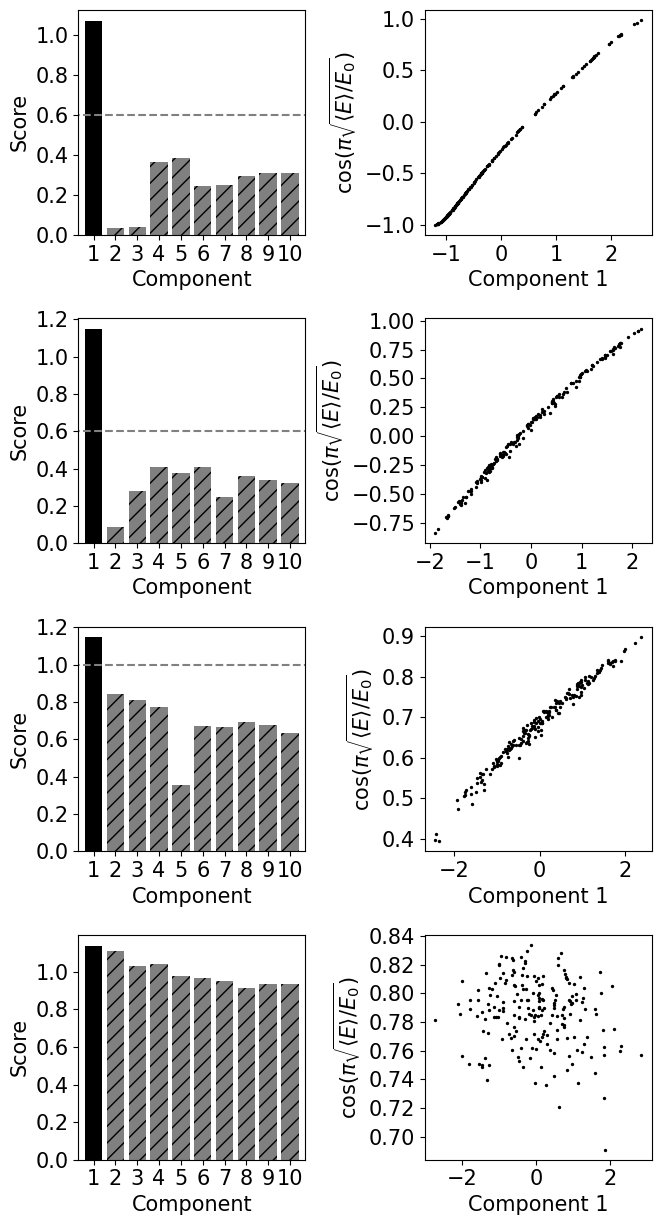

In [93]:
print(out_name)
with plt.style.context("default"):
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(7,12.5))

    for i in range(4):
        if i < 2:
            threshold = 0.6
        elif i == 2:
            threshold = 1.0
        elif i == 3:
            threshold = 1.12

        plt.subplot(4,2,2*i+1)
        n_show_components = 10
        plt.bar(
            list(range(1, n_components+1)[:n_show_components]),
            scores_pass_list[i][:n_show_components],
            color="k",
        )
        plt.bar(
            list(range(1, n_components+1)[:n_show_components]),
            scores_fail_list[i][:n_show_components],
            hatch="//",
            color="gray",
        )
        plt.xticks(ticks=range(1, n_components+1)[:n_show_components])
        plt.xlim(0.3, n_show_components + 0.7)
        # plt.ylim(0, 1)
        plt.ylabel("Score")
        plt.xlabel("Component")
        if i < 3:
            plt.hlines(threshold, 0, n_show_components+1, "gray", linestyles="dashed")

        plt.subplot(4,2,2*i+2)
        sgn = -1 if i == 0 else 1
        plt.scatter(sgn*embedding_list[i][:, 0], np.cos(np.pi*np.sqrt(averageE[i])), c="k", s=2)
        plt.xlabel("Component 1")
        plt.ylabel("$\cos(\pi\sqrt{\langle E \\rangle/E_0})$")

    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_embedding.pdf", bbox_inches="tight")

# Varying $\gamma$ and $\tau$

In [99]:
rng = np.random.default_rng(0)
theta = 2 * np.pi * rng.uniform(size=200)
E = rng.uniform(size=(200))
init_x = np.sqrt(2*E[:, None]) * np.stack([np.cos(theta), np.sin(theta)], axis=-1)

# gamma = 1e-1
# tau = 1e0

for gamma in [1e-3, 1e-2, 1e-1]:
    for tau in [2e-3, 2e-2, 2e-1]:
        A = np.array([[0, 1], [-1, -gamma]])
        G = np.diag(np.sqrt(2*gamma*tau)*np.ones(2))
        tspan = np.linspace(0.0, 20000., 200001)

        seeds = (1e10 * rng.uniform(size=200)).astype(int)

        def itoint_(x, seed):
            return itoint(lambda x, t: A @ x, lambda x, t: G, x, tspan, generator=np.random.default_rng(seed))

        data = np.stack(Parallel(n_jobs=200)(delayed(itoint_)(x, seed) for x, seed in zip(init_x, seeds)))
        datasets = [data[:,:200:1], data[:,:2000:10], data[:,:20000:100], data[:,:200000:1000]]
        averageE = [np.mean(0.5 * np.sum(x**2, axis=-1), axis=-1) for x in datasets]

        out_name = "langevin_sho_gamma" + str(gamma) + "_tau" + str(tau)
        np.savez("data/" + out_name + ".npz", data=np.stack(datasets), params=np.stack(averageE))

        dist_mats = []
        for data in datasets:
            dist_mat, converged, _ = metrics.distance_matrix(data, mesh_shape=(4,2))
            assert converged.all()
            dist_mats.append(dist_mat)

        np.savez(out_name + "_dist_mats.npz", dist_mats=np.stack(dist_mats))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


langevin_sho_gamma0.1_tau0.2


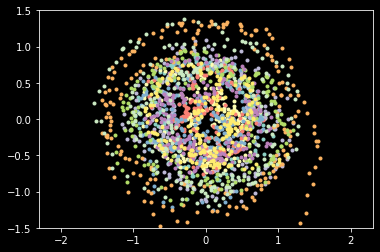

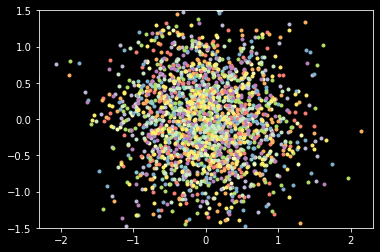

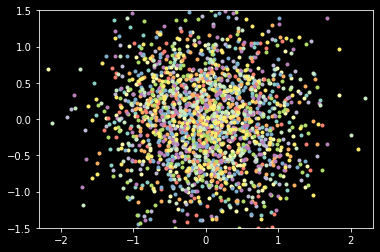

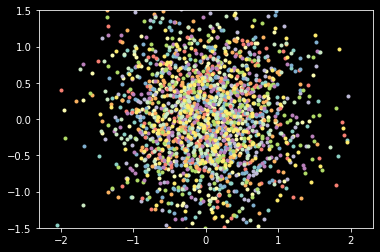

In [100]:
print(out_name)
for i in range(len(datasets)):
    plt.figure()
    plt.plot(datasets[i][:10, :, 0].T, datasets[i][:10, :, 1].T, '.')
    plt.axis('equal')
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)

In [2]:
from scipy.stats import spearmanr

prominences = np.zeros((3, 3, 4)) 
rhos = np.zeros((3, 3, 4))

for i, gamma in enumerate([1e-3, 1e-2, 1e-1]):
    for j, tau in enumerate([2e-3, 2e-2, 2e-1]):
        out_name = "langevin_sho_gamma" + str(gamma) + "_tau" + str(tau)
        dist_mats = np.load(out_name + "_dist_mats.npz")['dist_mats']
        averageE = np.load("data/" + out_name + ".npz")['params']

        # scores_pass_list = []
        # scores_fail_list = []
        # embedding_list = []
        for k, dist_mat in enumerate(dist_mats):
            evals, embedding, epsilon = manifold.diffusion_map(dist_mat, n_components=20, epsilon='max', n_neighbors=20, alpha=1, robust=True)
            # # embedding_list.append(embedding)
            print(i, j, k)
            
            if i == 1 and k == 3:
                threshold = 1.12
            elif i == 2 and j < 2 and k >= 2:
                threshold = 1.1
            elif i == 2 and j == 2 and k >= 2:
                threshold = 1.13
            else:
                threshold = 1.
            n_components = evals.shape[0]

            embed_list, scores_pass, scores_fail = manifold.heuristic_importance_score(evals, embedding, threshold=threshold, weights="adjusted")
            # # scores_pass_list.append(scores_pass)
            # # scores_fail_list.append(scores_fail)

            assert len(embed_list) == 1
            prominence = np.max(scores_pass) - np.max(scores_fail)
            prominences[i, j, k] = prominence
            rhos[i, j, k] = spearmanr(embedding[:,0], averageE[k]).correlation

nn_max = 0.4316776692867279
epsilon = 0.37269122032164326
mean_shift = 0.008812527
0 0 0
nn_max = 0.39825645089149475
epsilon = 0.31721640135337914
mean_shift = 0.008816935
0 0 1
nn_max = 0.2909121811389923
epsilon = 0.16925979427009175
mean_shift = 0.009141926
0 0 2
nn_max = 0.11293170601129532
epsilon = 0.02550714044524327
mean_shift = 0.0102516385
0 0 3
nn_max = 0.40697792172431946
epsilon = 0.3312620575420926
mean_shift = 0.009269698
0 1 0
nn_max = 0.3325560986995697
epsilon = 0.2211871175645559
mean_shift = 0.010209237
0 1 1
nn_max = 0.3044700026512146
epsilon = 0.18540396502886125
mean_shift = 0.009551482
0 1 2
nn_max = 0.2140466421842575
epsilon = 0.09163193006071113
mean_shift = 0.006583472
0 1 3
nn_max = 0.44064489006996155
epsilon = 0.388335838289537
mean_shift = 0.008534818
0 2 0
nn_max = 0.3892613351345062
epsilon = 0.30304877406139674
mean_shift = 0.009793449
0 2 1
nn_max = 0.8279898166656494
epsilon = 1.3711342730040315
mean_shift = 0.0061941743
0 2 2
nn_max = 0.360206216

In [3]:
rhos

array([[[ 0.999973  , -0.9999865 , -0.9999505 , -0.99678692],
        [ 0.999982  ,  0.999976  ,  0.99798395,  0.99263782],
        [ 0.999982  , -0.999811  ,  0.99538288,  0.99786995]],

       [[-0.99997   ,  0.999952  ,  0.99708693, -0.04720618],
        [ 0.999958  , -0.99833496,  0.98128253, -0.03334583],
        [ 0.99979299, -0.99536938,  0.99707343,  0.09076727]],

       [[ 0.9998965 ,  0.99763744, -0.15437336, -0.04130203],
        [-0.99860947, -0.98367059, -0.45889297, -0.0721818 ],
        [-0.9961614 ,  0.99808445, -0.98882622,  0.01917048]]])

In [4]:
prominences

array([[[0.64149481, 0.91763961, 0.72432318, 0.56335944],
        [0.67332211, 0.85539249, 0.68441546, 0.25174081],
        [0.66138569, 0.78726217, 0.39975297, 0.41223431]],

       [[0.6672473 , 0.74661288, 0.4397608 , 0.11636567],
        [0.69691104, 0.76603037, 0.31738669, 0.02204168],
        [0.79724371, 0.52151614, 0.35522956, 0.06967807]],

       [[0.68820545, 0.54379296, 0.12027216, 0.15124357],
        [0.68868381, 0.23509389, 0.0603019 , 0.08230567],
        [0.40136373, 0.25788301, 0.01650679, 0.03331947]]])

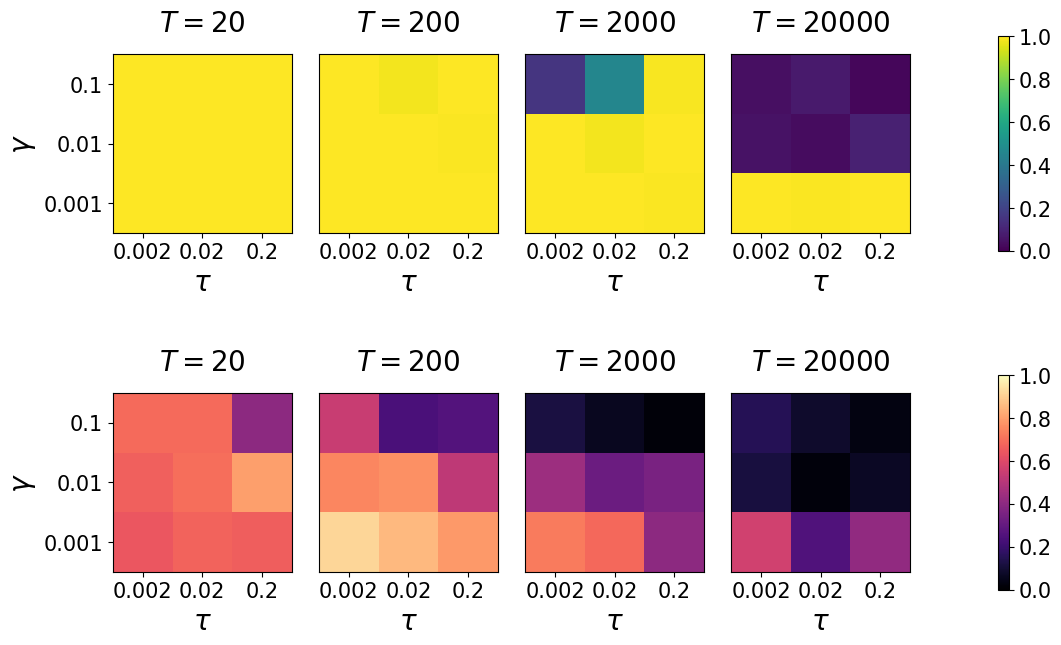

In [72]:
with plt.style.context("default"):
    plt.rcParams.update({'font.size': 15, 'axes.titley' : 0.9}) 
    fig, axs = plt.subplots(2,5,figsize=(11,7), gridspec_kw={'width_ratios': [1, 1, 1, 1, 0.4]})

    for i in range(4):
        axs[0,i].imshow(np.abs(rhos[:,:,i]), vmin=0, vmax=1, origin="lower")
        axs[0,i].set_xticks([0, 1, 2], [0.002, 0.02, 0.2])
        axs[0,i].set_xlabel("$\\tau$", fontsize=20)
        axs[0,i].set_title(f"$T={20 * 10**i}$\n", fontsize=20)
        axs[0,i].set_yticks([])

        axs[1,i].imshow(prominences[:,:,i], vmin=0, vmax=1, origin="lower", cmap="magma")
        axs[1,i].set_xticks([0, 1, 2], [0.002, 0.02, 0.2])
        axs[1,i].set_xlabel("$\\tau$", fontsize=20)
        axs[1,i].set_title(f"$T={20 * 10**i}$\n", fontsize=20)
        axs[1,i].set_yticks([])

    axs[0,0].set_ylabel("$\gamma$", fontsize=20)
    axs[0,0].set_yticks([0, 1, 2], [0.001, 0.01, 0.1])
    axs[1,0].set_ylabel("$\gamma$", fontsize=20)
    axs[1,0].set_yticks([0, 1, 2], [0.001, 0.01, 0.1])
        
    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 1), cmap='viridis'), ax=axs[0,4])
    axs[0,4].remove()
    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 1), cmap='magma'), ax=axs[1,4])
    axs[1,4].remove()

    plt.tight_layout()
    plt.savefig(f"figures/langevin_sho_varying.pdf", bbox_inches="tight")

In [ ]:
# print(out_name)
# with plt.style.context("default"):
#     plt.rcParams.update({'font.size': 15})
#     plt.figure(figsize=(7,12.5))

#     for i in range(4):
#         # if i < 2:
#         #     threshold = 0.6
#         # elif i == 2:
#         #     threshold = 1.0
#         # elif i == 3:
#         #     threshold = 1.12
#         threshold = 1.12

#         plt.subplot(4,2,2*i+1)
#         n_show_components = 10
#         plt.bar(
#             list(range(1, n_components+1)[:n_show_components]),
#             scores_pass_list[i][:n_show_components],
#             color="k",
#         )
#         plt.bar(
#             list(range(1, n_components+1)[:n_show_components]),
#             scores_fail_list[i][:n_show_components],
#             hatch="//",
#             color="gray",
#         )
#         plt.xticks(ticks=range(1, n_components+1)[:n_show_components])
#         plt.xlim(0.3, n_show_components + 0.7)
#         # plt.ylim(0, 1)
#         plt.ylabel("Score")
#         plt.xlabel("Component")
#         if i < 3:
#             plt.hlines(threshold, 0, n_show_components+1, "gray", linestyles="dashed")

#         plt.subplot(4,2,2*i+2)
#         sgn = -1 if i == 0 else 1
#         plt.scatter(sgn*embedding_list[i][:, 0], np.cos(np.pi*np.sqrt(averageE[i])), c="k", s=2)
#         plt.xlabel("Component 1")
#         plt.ylabel("$\cos(\pi\sqrt{\langle E \\rangle/E_0})$")

#     plt.tight_layout()
#     # plt.savefig(f"figures/{out_name}_embedding.pdf", bbox_inches="tight")